In [1]:
#!pip install fasttreeshap
#!pip install scipy numpy
# Importing the necessary packages and setting the enviroment
import warnings
warnings.filterwarnings("ignore")


import time, psutil, os, gc

# Mathematical functions
import math

# Data manipulation
import numpy as np
np.bool = np.bool_
import pandas as pd
import matplotlib.pyplot as plt
import shap  # For SHAP values explanation
# Fit SHAP explainer and obtain SHAP values f
# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Train-test split
from sklearn.model_selection import train_test_split

# Progress bar for loop
from tqdm.contrib import itertools

# Data

Source: https://www.kaggle.com/mlg-ulb/creditcardfraud

The dataset contains information on the transactions made using credit cards by European cardholders, in two particular days of September 2013
. It presents a total of 284807 transactions, of which 492 were fraudulent. Clearly, the dataset is highly imbalanced, the positive class (fraudulent transactions) accounting for only 0.173%

of all transactions. The columns in the dataset are as follows:

Time: The time (in seconds) elapsed between the transaction and the very first transaction 

V1 to V28: Obtained from principle component analysis (PCA) transformation on original features that are not available due to confidentiality

Amount: The amount of the transaction

Class: The status of the transaction with respect to authenticity. The class of an authentic (resp. fraudulent) transaction is taken to be 0

In [2]:
df = pd.read_csv("creditcard.csv")
# Check the shape of the dataset
print("Shape of the dataset:", df.shape)
# Check the first few rows of the dataset
data=df
df.head()

Shape of the dataset: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Sub-sample with all minority class retained.

To improve on computational efficiecy of shap calculations, we are doing a sub-sample of n=50000, where all the minority class (fraudulent transactions) are retained.

In [3]:
df=data
# Calculate the class distribution in the original DataFrame
class_counts = df['Class'].value_counts()

# Identify minority classes
minority_classes = class_counts[class_counts < df.shape[0] // len(class_counts)].index.tolist()

# Create a sub-sample DataFrame
sub_sample = pd.DataFrame()

# Desired size of the sub-sample
desired_size = 100000

# Add all instances of minority classes
for cls in minority_classes:
    class_subset = df[df['Class'] == cls]
    sub_sample = pd.concat([sub_sample, class_subset], axis=0)

# For majority classes, sample with replacement to reach desired size
for cls in df['Class'].unique():
    if cls not in minority_classes:
        class_subset = df[df['Class'] == cls]
        num_samples = min(len(class_subset), desired_size - len(sub_sample))
        class_subset_sampled = class_subset.sample(n=num_samples, replace=True, random_state=1)
        sub_sample = pd.concat([sub_sample, class_subset_sampled], axis=0)
        if len(sub_sample) >= desired_size:
            break

# Shuffle the sub-sample to mix the classes (optional)
sub_sample = sub_sample.sample(frac=1, random_state=1).reset_index(drop=True)
df=sub_sample
df = df.fillna(df.mean())
df.shape

(100000, 31)

In [4]:
df['Day'], temp = df['Time'] // (24*60*60), df['Time'] % (24*60*60)
df['Hour'], temp = temp // (60*60), temp % (60*60)
df['Minute'], df['Second'] = temp // 60, temp % 60
df[['Time', 'Day', 'Hour', 'Minute', 'Second']].tail()
df['Amount'] = np.log10(df['Amount'] + 0.001)
df.shape

(100000, 35)

In [5]:
df=df.fillna(df.mean())
X=df.drop('Class',axis=1)
y=df['Class']

# Feature Selection

In [6]:
ind=[3,6,8,9,10,11,13,15,16,17]
cols=[]
for i in ind:
    cols.append(df.columns[i])
cols

['V3', 'V6', 'V8', 'V9', 'V10', 'V11', 'V13', 'V15', 'V16', 'V17']

In [7]:
col=['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Day', 'Hour', 'Minute', 'Second']

In [8]:
X=X[col]

In [9]:
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Day,Hour,Minute,Second
0,83099.0,-0.706925,-0.227413,0.810964,-1.908891,2.102545,3.499152,-0.857305,1.094489,0.842533,...,1.027330,0.464595,-0.490993,0.149410,0.094876,0.000434,0.0,23.0,4.0,59.0
1,38156.0,1.376468,-0.526020,0.682003,-0.652070,-1.241965,-0.964044,-0.662006,-0.155276,-0.669430,...,0.380366,0.234955,-0.412454,0.014778,0.026196,1.311775,0.0,10.0,35.0,56.0
2,135590.0,0.566742,-3.239704,-1.865361,-1.637002,-0.831041,0.906625,0.172834,0.265449,2.469764,...,-1.453057,-0.752981,-1.220133,-0.019662,0.058652,2.846820,1.0,13.0,39.0,50.0
3,82501.0,-0.880970,0.204653,2.467321,-0.538077,0.006734,0.142517,0.888193,-0.244358,-0.139762,...,0.244885,0.060451,0.066472,-0.420440,-0.522810,2.033428,0.0,22.0,55.0,1.0
4,76858.0,1.135711,-0.916677,0.259080,-2.027512,-1.014767,-0.569478,-0.444145,-0.125706,2.377299,...,-0.369768,0.784563,-0.602417,0.090398,0.043735,2.047512,0.0,21.0,20.0,58.0


# Scaling and Splitting the data

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit and transform the data
X =(X-X.mean())/X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
data_train=X_train
label_train=y_train
test=X_test
label_test=y_test

# Load Python libraries

In [11]:
import os
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.metrics import roc_auc_score, accuracy_score
#import umap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import IsolationForest
from lightgbm import LGBMClassifier
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
import fasttreeshap
import time

# Train a random forest model using scikit-learn and compute SHAP values

In [51]:
n_estimators = 200  # number of trees in random forest model
max_depth = 8  # maximum depth of any trees in random forest model

In [52]:
# train a random forest model
rf_model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, random_state = 0)
rf_model.fit(data_train, label_train)
print("AUC on testing set is {:.2f}.".format(roc_auc_score(label_test, rf_model.predict_proba(test)[:, 1])))
print("Accuracy on testing set is {:.2f}.".format(accuracy_score(label_test, rf_model.predict(test))))

AUC on testing set is 0.98.
Accuracy on testing set is 1.00.


In [53]:
# obtain total number of leaves
shap_explainer = fasttreeshap.TreeExplainer(rf_model)
num_leaves = sum(shap_explainer.model.num_nodes) - sum(sum(shap_explainer.model.children_left > 0))
print("Total number of leaves is {}.".format(num_leaves))

Total number of leaves is 7926.


In [54]:
# estimate memory usage of FastTreeSHAP v2 since FastTreeSHAP v2 has a stricter memory constraint than
# TreeSHAP and FastTreeSHAP v1
# derivation of the memory estimation can be found in Deep Dive Section in this notebook
def memory_estimate_v2(shap_explainer, num_sample, num_feature, n_jobs):
    max_node = max(shap_explainer.model.num_nodes)
    max_leaves = (max_node + 1) // 2
    max_combinations = 2**int(shap_explainer.model.max_depth)
    phi_dim = num_sample * (num_feature + 1) * shap_explainer.model.num_outputs
    n_jobs = os.cpu_count() if n_jobs == -1 else n_jobs
    memory_1 = (max_leaves * max_combinations + phi_dim) * 8 * n_jobs
    memory_2 = max_leaves * max_combinations * shap_explainer.model.values.shape[0] * 8
    memory = min(memory_1, memory_2)
    if memory < 1024:
        print("Memory usage of FastTreeSHAP v2 is around {:.2f}B.".format(memory))
    elif memory / 1024 < 1024:
        print("Memory usage of FastTreeSHAP v2 is around {:.2f}KB.".format(memory / 1024))
    elif memory / 1024**2 < 1024:
        print("Memory usage of FastTreeSHAP v2 is around {:.2f}MB.".format(memory / 1024**2))
    else:
        print("Memory usage of FastTreeSHAP v2 is around {:.2f}GB.".format(memory / 1024**3))


# Compute SHAP values via different versions of TreeSHAP

In [55]:
num_sample = 10000  # number of samples to be explained
n_jobs = -1  # number of parallel threads (-1 means utilizing all available cores)

In [56]:
# compute SHAP values via FastTreeSHAP v0 (i.e., original TreeSHAP)
# parallel computing is not enabled in original TreeSHAP in SHAP package, but here we enable it for a fair comparison
# on execution time
shap_explainer = fasttreeshap.TreeExplainer(rf_model, algorithm = "v0", n_jobs = n_jobs)
shap_values_v0 = shap_explainer(test.iloc[:num_sample]).values
shap_values_v0.shape

(10000, 34, 2)

In [ ]:
# compute SHAP values via FastTreeSHAP v1
shap_explainer = fasttreeshap.TreeExplainer(rf_model, algorithm = "v1", n_jobs = n_jobs)
shap_values_v1 = shap_explainer(test.iloc[:num_sample]).values
shap_values_v1.shape

In [ ]:
# justify the correctness of FastTreeSHAP v1
print("Maximum difference of SHAP values between v1 and v0 is {:.2e}.".format(
    np.max(abs(shap_values_v1 - shap_values_v0))))

In [ ]:
# estimate memory usage of FastTreeSHAP v2 since FastTreeSHAP v2 has a stricter memory constraint than
# TreeSHAP and FastTreeSHAP v1
memory_estimate_v2(shap_explainer, num_sample, test.shape[1], n_jobs)

In [ ]:
# compute SHAP values via FastTreeSHAP v2
shap_explainer = fasttreeshap.TreeExplainer(rf_model, algorithm = "v2", n_jobs = n_jobs)
shap_values_v2 = shap_explainer(test.iloc[:num_sample]).values
shap_values_v2.shape

In [ ]:
# justify the correctness of FastTreeSHAP v2
print("Maximum difference of SHAP values between v2 and v0 is {:.2e}.".format(
    np.max(abs(shap_values_v2 - shap_values_v0))))

In [ ]:
# compute SHAP values via automatic TreeSHAP algorithm selection
shap_explainer = fasttreeshap.TreeExplainer(rf_model, algorithm = "auto", n_jobs = n_jobs)
shap_values_auto = shap_explainer(test.iloc[:num_sample]).values
shap_values_auto.shape

In [ ]:
# justify the correctness of automatically selected TreeSHAP algorithm
# it turns out that "auto" selects "v2" as the most appropriate TreeSHAP algorithm
print("Maximum difference of SHAP values between auto and v0 is {:.2e}.".format(
    np.max(abs(shap_values_auto - shap_values_v0))))


# Compare running times of different versions of TreeSHAP in computing SHAP values



In [ ]:
# compute SHAP values/SHAP interaction values via TreeSHAP algorithm with version "algorithm_version"
# (parallel on "n_jobs" threads)
def run_fasttreeshap(model, sample, interactions, algorithm_version, n_jobs, num_round, num_sample, shortcut = False):
    shap_explainer = fasttreeshap.TreeExplainer(
        model, algorithm = algorithm_version, n_jobs = n_jobs, shortcut = shortcut)
    run_time = np.zeros(num_round)
    for i in range(num_round):
        start = time.time()
        shap_values = shap_explainer(sample.iloc[:num_sample], interactions = interactions).values
        run_time[i] = time.time() - start
        print("Round {} takes {:.3f} sec.".format(i + 1, run_time[i]))
    print("Average running time of {} is {:.3f} sec (std {:.3f} sec){}.".format(
        algorithm_version, np.mean(run_time), np.std(run_time), " (with shortcut)" if shortcut else ""))


In [ ]:
num_sample = 10000  # number of samples to be explained
num_round = 3  # number of rounds to record mean and standard deviation of running time
n_jobs = -1  # number of parallel threads (-1 means utilizing all available cores)

In [ ]:
# run FastTreeSHAP v0 (i.e., original TreeSHAP) multiple times and record its average running time
# parallel computing is not enabled in original TreeSHAP in SHAP package, but here we enable it for a fair comparison
# on execution time
run_fasttreeshap(
    model = rf_model, sample = test, interactions = False, algorithm_version = "v0", n_jobs = n_jobs,
    num_round = num_round, num_sample = num_sample)

In [ ]:
# run FastTreeSHAP v1 multiple times and record its average running time
run_fasttreeshap(
    model = rf_model, sample = test, interactions = False, algorithm_version = "v1", n_jobs = n_jobs, 
    num_round = num_round, num_sample = num_sample)

In [ ]:
# run automatically selected TreeSHAP algorithm multiple times and record its average running time
# it turns out that "auto" selects "v2" as the most appropriate TreeSHAP algorithm
run_fasttreeshap(
    model = rf_model, sample = test, interactions = False, algorithm_version = "v2", n_jobs = n_jobs, 
    num_round = num_round, num_sample = num_sample)

# Compute SHAP interaction values via different versions of TreeSHAP

In [ ]:
num_sample = 100  # number of samples to be explained
n_jobs = -1  # number of parallel threads (-1 means utilizing all available cores)

In [ ]:
# compute SHAP interaction values via FastTreeSHAP v0 (i.e., original TreeSHAP)
# parallel computing is not enabled in original TreeSHAP in SHAP package, but here we enable it for a fair comparison
# on execution time
shap_explainer = fasttreeshap.TreeExplainer(rf_model, algorithm = "v0", n_jobs = n_jobs)
shap_interaction_values_v0 = shap_explainer(test.iloc[:num_sample], interactions = True).values
shap_interaction_values_v0.shape

In [ ]:
#compute SHAP interaction values via FastTreeSHAP v1
shap_explainer = fasttreeshap.TreeExplainer(rf_model, algorithm = "v1", n_jobs = n_jobs)
shap_interaction_values_v1 = shap_explainer(test.iloc[:num_sample], interactions = True).values
shap_interaction_values_v1.shape

In [ ]:
# justify the correctness of FastTreeSHAP v1
print("Maximum difference of SHAP interaction values between v1 and v0 is {:.2e}.".format(
    np.max(abs(shap_interaction_values_v1 - shap_interaction_values_v0))))

In [ ]:
 #compute SHAP interaction values via automatic TreeSHAP algorithm selection
# v1 is always preferred to v0 in any use cases, and v2 does not support interactions
shap_explainer = fasttreeshap.TreeExplainer(rf_model, algorithm = "auto", n_jobs = n_jobs)
shap_interaction_values_auto = shap_explainer(test.iloc[:num_sample], interactions = True).values
shap_interaction_values_auto.shape

In [ ]:
# justify the correctness of automatically selected TreeSHAP algorithm
print("Maximum difference of SHAP interaction values between auto and v0 is {:.2e}.".format(
    np.max(abs(shap_interaction_values_auto - shap_interaction_values_v0))))

# Compare running times of different versions of TreeSHAP in computing SHAP interaction values

In [ ]:
num_sample = 100  # number of samples to be explained
num_round = 3  # number of rounds to record mean and standard deviation of running time
n_jobs = -1  # number of parallel threads (-1 means utilizing all available cores)


In [ ]:
# run FastTreeSHAP v0 (i.e., original TreeSHAP) multiple times and record its average running time
# parallel computing is not enabled in original TreeSHAP in SHAP package, but here we enable it for a fair comparison
# on execution time
run_fasttreeshap(
    model = rf_model, sample = test, interactions = True, algorithm_version = "v0", n_jobs = n_jobs, 
    num_round = num_round, num_sample = num_sample)

In [ ]:
# run FastTreeSHAP v1 multiple times and record its average running time
run_fasttreeshap(
    model = rf_model, sample = test, interactions = True, algorithm_version = "v1", n_jobs = n_jobs, 
    num_round = num_round, num_sample = num_sample)

In [ ]:
# run automatically selected TreeSHAP algorithm multiple times and record its average running time
# v1 is always preferred to v0 in any use cases, and v2 does not support interactions
run_fasttreeshap(
    model = rf_model, sample = test, interactions = True, algorithm_version = "auto", n_jobs = n_jobs, 
    num_round = num_round, num_sample = num_sample)

# Varying number of RF Estimators

In [15]:
# compute SHAP values/SHAP interaction values via TreeSHAP algorithm with version "algorithm_version"
# (parallel on "n_jobs" threads)
def run_time_fasttreeshap(model, sample, interactions, algorithm_version, n_jobs, num_round, num_sample, shortcut = False):
    shap_explainer = fasttreeshap.TreeExplainer(
        model, algorithm = algorithm_version, n_jobs = n_jobs, shortcut = shortcut)
    run_time = np.zeros(num_round)
    for i in range(num_round):
        start = time.time()
        shap_values = shap_explainer(sample.iloc[:num_sample], interactions = interactions).values
        run_time[i] = time.time() - start
    return  np.mean(run_time), np.std(run_time)

num_sample = 100  # number of samples to be explained
num_round = 3  # number of rounds to record mean and standard deviation of running time
n_jobs = -1 

N_Est=[10*i for i in range(1,2) ]
T_V0=[]
T_V1=[]
T_V2=[]
for i in N_Est:
    model=RandomForestClassifier(criterion='entropy', max_depth=8, max_features=0.31096155614096943,
                       max_leaf_nodes=161, n_estimators=i, n_jobs=-1)
    model.fit(X_train, y_train)
    start_time = time.time()
    shap_explainer=fasttreeshap.TreeExplainer(model, algorithm='v0',n_jobs=-1)
    shap_values=shap_explainer(X_test).values
    shap_values.shape
    Elapsed_time = time.time()-start_time 
    T_V0.append(Elapsed_time)
for i in N_Est:
    model=RandomForestClassifier(criterion='entropy', max_depth=8, max_features=0.31096155614096943,
                       max_leaf_nodes=161, n_estimators=i, n_jobs=-1)
    model.fit(X_train, y_train)
    start_time = time.time()
    shap_explainer=fasttreeshap.TreeExplainer(model, algorithm='v1',n_jobs=-1)
    shap_values=shap_explainer(X_test).values
    shap_values.shape
    Elapsed_time = time.time()-start_time 
    T_V1.append(Elapsed_time) 
    
for i in N_Est:
    model=RandomForestClassifier(criterion='entropy', max_depth=8, max_features=0.31096155614096943,
                       max_leaf_nodes=161, n_estimators=i, n_jobs=-1)
    model.fit(X_train, y_train)
    start_time = time.time()
    shap_explainer=fasttreeshap.TreeExplainer(model, algorithm='v2',n_jobs=-1)
    shap_values=shap_explainer(X_test).values
    shap_values.shape
    Elapsed_time = time.time()-start_time 
    T_V2.append(Elapsed_time) 

# (a) Varying number of Samples

In [29]:
from sklearn.ensemble import IsolationForest

In [30]:
num_sample =[1000*i for i in range(1,11)]# number of samples to be explained
num_round = 6  # number of rounds to record mean and standard deviation of running time
n_jobs = -1 

N_Est=[40*i for i in range(1,11) ]
Versions=['v0','v1','v2']
Samp=[1000*i for i in range(1,11)]
T_V0=[]
for i in num_sample:
    model=IsolationForest(n_estimators = 100, random_state = 0)
    model.fit(data_train,label_train)
    time_stat=run_time_fasttreeshap(model = model, sample = test,interactions=False, algorithm_version ='v0', n_jobs = n_jobs, 
        num_round = num_round, num_sample= i)
    print(time_stat)
    T_V0.append(time_stat[0])

(0.5708338816960653, 0.02404694625044179)
(1.1837727626164753, 0.05819685782946202)
(2.02340030670166, 0.12452890749189975)
(4.318320433298747, 0.8289482831142257)
(5.749478022257487, 0.2934630128705679)
(7.403425574302673, 0.5357622946021707)
(8.180742104848227, 0.47430018371282284)
(8.966914614041647, 0.22018208370919956)
(9.528568704922995, 0.3627762795599402)
(11.031246105829874, 0.6494047354611301)


In [31]:
T_V1=[]
for i in num_sample :
    model=IsolationForest(n_estimators = 100, random_state = 0)
    model.fit(data_train,label_train)
    time_stat=run_time_fasttreeshap(model = model, sample = test,interactions=False, algorithm_version = "v1", n_jobs = n_jobs, 
    num_round = num_round, num_sample= i)
    print(time_stat)
    T_V1.append(time_stat[0])

(0.9716561237970988, 0.15954729180425994)
(1.8367234865824382, 0.28530335526114753)
(2.9522433280944824, 0.39151581647842926)
(4.466206669807434, 0.2606314330602708)
(4.253476659456889, 0.7853212672419396)
(4.806585192680359, 0.8699161151773028)
(9.060787359873453, 1.2464712499023616)
(7.250366727511088, 2.442196528831107)
(6.168215115865071, 1.1781674096729498)
(6.868430932362874, 0.4123100128773672)


In [32]:
T_V2=[]
for i in num_sample :
    model=IsolationForest(n_estimators = 100, random_state = 0)
    model.fit(data_train,label_train)
    time_stat=run_time_fasttreeshap(model = model, sample = test,interactions=False, algorithm_version = "v2", n_jobs = n_jobs, 
    num_round = num_round, num_sample =i)
    print(time_stat)
    T_V2.append(time_stat[0])

(0.31993985176086426, 0.028371592794977026)
(0.7177730401357015, 0.09987590745586439)
(1.000340461730957, 0.11716334763465613)
(1.979068438212077, 0.29782912076110934)
(1.8380324840545654, 0.07963057705199243)
(1.8590434392293294, 0.1046821121312411)
(2.8667415380477905, 0.11155329699714307)
(3.2494647105534873, 0.1272686331066231)
(3.3714956442515054, 0.34057989203282263)
(3.0407004356384277, 0.308874529425556)


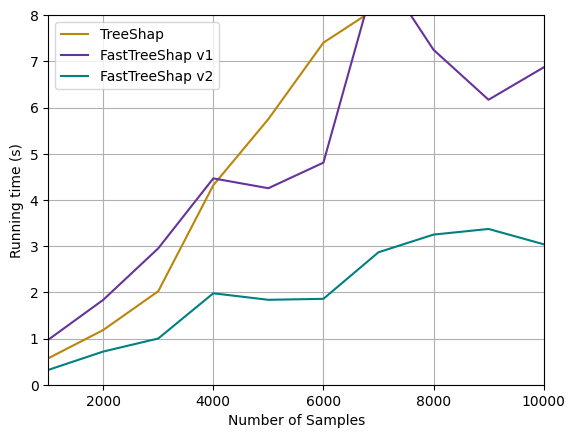

In [33]:
plt.plot(num_sample,T_V0, color='darkgoldenrod')
plt.plot(num_sample,T_V1, color='rebeccapurple')
plt.plot(num_sample,T_V2, color='teal')
plt.legend(['TreeShap','FastTreeShap v1','FastTreeShap v2'])
plt.grid(True)
plt.xlabel('Number of Samples')
plt.ylabel('Running time (s)')
plt.xlim(1000, 10010) 
plt.ylim(0, 8) 
plt.savefig("FastShap_Credit Data_sample_IF.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

In [34]:
AV_SU_V1=np.mean(np.array(T_V0)/np.array(T_V1))
AV_SU_V2=np.mean(np.array(T_V0)/np.array(T_V2))
AV_SU_V1,AV_SU_V2

(1.106672405739878, 2.6815830375458973)

# (b) Varying the maximum depth

Max_dpth =[2*i for i in range(1,7)]# number of samples to be explained
num_round = 3  # number of rounds to record mean and standard deviation of running time
n_jobs = -1 

N_Est=[40*i for i in range(1,11) ]
Versions=['v0','v1','v2']
Samp=[1000*i for i in range(1,11)]
T1_V0=[]
for i in Max_dpth:
    model=RandomForestClassifier(n_estimators = 100, max_depth = i, random_state = 0)
    model.fit(data_train,label_train)
    time_stat=run_time_fasttreeshap(model = model, sample = test, interactions = False, algorithm_version ='v0', n_jobs = n_jobs, 
        num_round = num_round, num_sample= 10000)
    print(time_stat)
    T1_V0.append(time_stat[0])

T1_V1=[]
for i in Max_dpth:
    model=RandomForestClassifier(n_estimators = 100, max_depth = i, random_state = 0)
    model.fit(data_train,label_train)
    time_stat=run_time_fasttreeshap(model = model, sample = test, interactions = False, algorithm_version ='v1', n_jobs = n_jobs, 
        num_round = num_round, num_sample= 10000)
    print(time_stat)
    T1_V1.append(time_stat[0])

T1_V2=[]
for i in Max_dpth:
    model=RandomForestClassifier(n_estimators = 100, max_depth = i, random_state = 0)
    model.fit(data_train,label_train)
    time_stat=run_time_fasttreeshap(model = model, sample = test, interactions = False, algorithm_version ='v2', n_jobs = n_jobs, 
        num_round = num_round, num_sample= 10000)
    print(time_stat)
    T1_V2.append(time_stat[0])

import matplotlib.pyplot as plt
plt.plot(Max_dpth,T1_V0, color='darkgoldenrod')
plt.plot(Max_dpth,T1_V1, color='rebeccapurple')
plt.plot(Max_dpth,T1_V2, color='teal')
plt.legend(['TreeShap','FastTreeShap v1','FastTreeShap v2'])
plt.grid(True)
plt.xlabel('Max_Depth')
plt.ylabel('Running time (s)')
plt.xlim(2, 12.01) 
plt.ylim(0, 25) 
plt.savefig("FastShap_Credit Data_depth.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

AV_SU_V1=np.mean(np.array(T1_V0)/np.array(T1_V1))
AV_SU_V2=np.mean(np.array(T1_V0)/np.array(T1_V2))
AV_SU_V1,AV_SU_V2

#  (c) Varying the  number of estimators

In [35]:
Max_dpth =[2*i for i in range(1,6)]# number of samples to be explained
num_round = 3  # number of rounds to record mean and standard deviation of running time
n_jobs = -1 

N_Est=[40*i for i in range(1,6) ]
Versions=['v0','v1','v2']
Samp=[1000*i for i in range(1,11)]
T2_V0=[]
for i in N_Est:
    model=IsolationForest(n_estimators = i, random_state = 0)
    model.fit(data_train,label_train)
    time_stat=run_time_fasttreeshap(model = model, sample = test, interactions = False, algorithm_version ='v0', n_jobs = n_jobs, 
        num_round = num_round, num_sample= 1000)
    print(time_stat)
    T2_V0.append(time_stat[0])

(0.2412892977396647, 0.008049247668954587)
(0.5465943813323975, 0.01962632622497368)
(0.7701144218444824, 0.013429009663340648)
(1.026442289352417, 0.02696390194944046)
(1.2741889953613281, 0.18961797846110112)


In [36]:
T2_V1=[]
for i in N_Est:
    model=IsolationForest(n_estimators = i, random_state = 0)
    model.fit(data_train,label_train)
    time_stat=run_time_fasttreeshap(model = model, sample = test, interactions = False, algorithm_version ='v1', n_jobs = n_jobs, 
        num_round = num_round, num_sample= 1000)
    print(time_stat)
    T2_V1.append(time_stat[0])

(0.23467286427815756, 0.0022390754378295873)
(0.4526376724243164, 0.033277298670615546)
(0.6560465494791666, 0.023898126801710665)
(0.9083726406097412, 0.05863012327266492)
(1.0454129378000896, 0.03405978087671594)


In [37]:
T2_V2=[]
for i in  N_Est:
    model=IsolationForest(n_estimators = i, random_state = 0)
    model.fit(data_train,label_train)
    time_stat=run_time_fasttreeshap(model = model, sample = test, interactions = False, algorithm_version ='v2', n_jobs = n_jobs, 
        num_round = num_round, num_sample= 1000)
    print(time_stat)
    T2_V2.append(time_stat[0])

(0.14397851626078287, 0.009583942657177385)
(0.235430637995402, 0.0035203217609572923)
(0.32440702120463055, 0.006536838545952795)
(0.44460709889729816, 0.015384311164341193)
(0.5305376847585043, 0.008842042988408497)


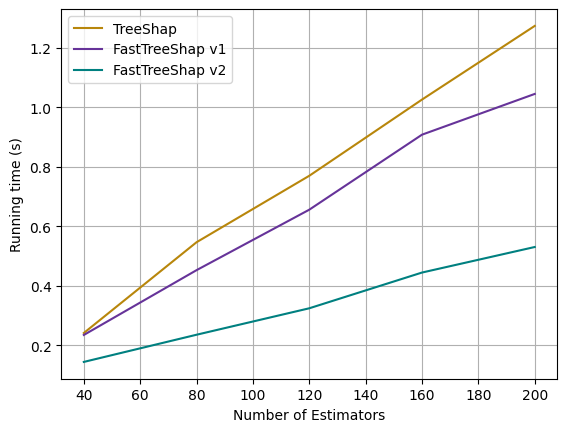

In [38]:
import matplotlib.pyplot as plt
plt.plot( N_Est,T2_V0, color='darkgoldenrod')
plt.plot( N_Est,T2_V1, color='rebeccapurple')
plt.plot( N_Est,T2_V2, color='teal')
plt.legend(['TreeShap','FastTreeShap v1','FastTreeShap v2'])
plt.grid(True)
plt.xlabel('Number of Estimators')
plt.ylabel('Running time (s)')
#plt.xlim(2, 12.01) 
#plt.ylim(0, 100) 
plt.savefig("FastShap_Credit Est_IF.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

In [39]:
AV_SU_V1=np.mean(np.array(T2_V0)/np.array(T2_V1))
AV_SU_V2=np.mean(np.array(T2_V0)/np.array(T2_V2))
AV_SU_V1,AV_SU_V2

(1.1516918341717008, 2.2163614559300817)

# Comparing Explanations: TreeShap vs FastTreeShap V1 vs  FastTreeShap V2

In [40]:
import os
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.metrics import roc_auc_score, accuracy_score
#import umap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import IsolationForest
from lightgbm import LGBMClassifier
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
import fasttreeshap
import time

In [41]:
import warnings
warnings.filterwarnings("ignore")
Modls=[ GradientBoostingClassifier(n_estimators=100),IsolationForest(n_estimators = 100,  random_state = 0),LGBMClassifier(learning_rate=0.054035619656969944, max_bin=511,
               min_child_samples=11, n_estimators=1360, num_leaves=44,
               reg_alpha=0.002947632445703634, reg_lambda=0.01268422625516522,
               verbose=-1)]
for model in Modls:
    model.fit(data_train,label_train)

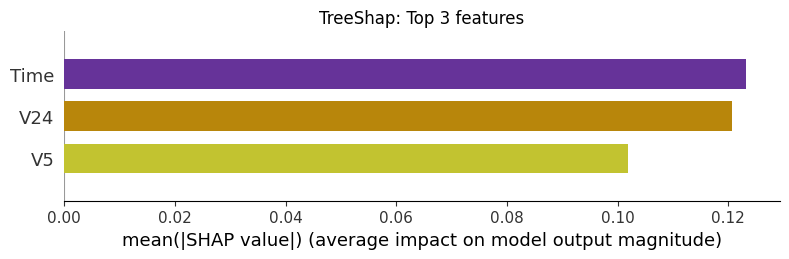

In [42]:
import matplotlib.pyplot as plt
import shap
explainer = fasttreeshap.TreeExplainer(Modls[1], algorithm="v0", n_jobs=n_jobs)
shap_values = explainer.shap_values(test,check_additivity=False)
# Assuming shap_values and test are defined elsewhere
colors = ['#c2c330', 'darkgoldenrod', 'rebeccapurple', '#ff3939', 'lime', 'cyan', 'teal']

# Plotting SHAP summary plot with bars for only 7 features
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
shap.summary_plot(shap_values, test, plot_type='bar', max_display=3, color=colors, show=False)

# Customizing the plot title
plt.title('TreeShap: Top 3 features')  # Replace with your desired title
# Display the plot
plt.tight_layout()
plt.savefig("Credit_Exp_Treshap_IF.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

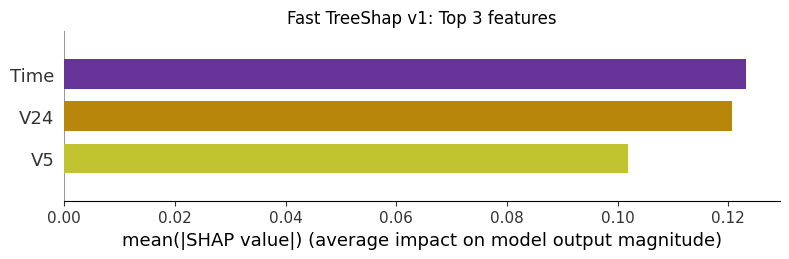

In [43]:
import matplotlib.pyplot as plt
import shap
explainer = fasttreeshap.TreeExplainer(Modls[1], algorithm="v1", n_jobs=n_jobs)
shap_values = explainer.shap_values(test,check_additivity=False)
# Assuming shap_values and test are defined elsewhere
colors = ['#c2c330', 'darkgoldenrod', 'rebeccapurple', '#ff3939', 'lime', 'cyan', 'teal']

# Plotting SHAP summary plot with bars for only 7 features
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
shap.summary_plot(shap_values, test, plot_type='bar', max_display=3, color=colors, show=False)

# Customizing the plot title
plt.title('Fast TreeShap v1: Top 3 features')  # Replace with your desired title
# Display the plot
plt.tight_layout()
plt.savefig("Credit_Exp_Fasttreeshapev1_IF.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

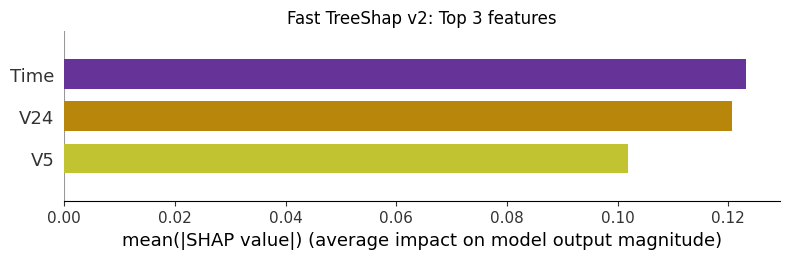

In [44]:
import matplotlib.pyplot as plt
import shap
explainer = fasttreeshap.TreeExplainer(Modls[1], algorithm="v2", n_jobs=n_jobs)
shap_values = explainer.shap_values(test,check_additivity=False)
# Assuming shap_values and test are defined elsewhere
colors = ['#c2c330', 'darkgoldenrod', 'rebeccapurple', '#ff3939', 'lime', 'cyan', 'teal']

# Plotting SHAP summary plot with bars for only 7 features
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
shap.summary_plot(shap_values, test, plot_type='bar', max_display=3, color=colors, show=False)

# Customizing the plot title
plt.title('Fast TreeShap v2: Top 3 features')  # Replace with your desired title
# Display the plot
plt.tight_layout()
plt.savefig("Credit_Exp_Fasttreeshapev2_IF.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()